In [17]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import List, Dict, Annotated
from operator import add
from IPython.display import Image, display

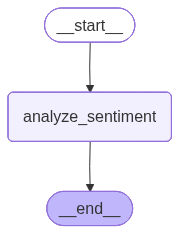

In [18]:
class FeedbackLog(TypedDict):
    id: str
    comment: str
    rating: int
    subject: str

class SentimentState(TypedDict):
    cleaned_logs: List[FeedbackLog]
    sentiment_summary: str
    processed_logs: List[str]


class SentimentOutput(TypedDict):
    sentiment_summary: str
    processed_logs: List[str]


def analyze_sentiment(state):
    logs = state["cleaned_logs"]
    # Simple dummy logic: if "good" appears, count as positive
    positive = sum("good" in log["comment"].lower() for log in logs)
    negative = len(logs) - positive
    sentiment_summary = f"{positive} positive and {negative} negative comments."
    return {"sentiment_summary": sentiment_summary,
            "processed_logs": [f"sentiment-log-{log['id']}" for log in logs]}


sentiment_builder = StateGraph(SentimentState, output_schema=SentimentOutput)
sentiment_builder.add_node("analyze_sentiment", analyze_sentiment)
sentiment_builder.add_edge(START, "analyze_sentiment")
sentiment_builder.add_edge("analyze_sentiment", END)

sentiment_graph = sentiment_builder.compile()
display(Image(sentiment_graph.get_graph().draw_mermaid_png()))

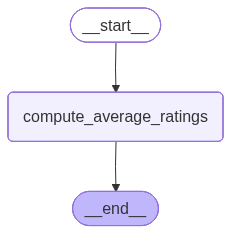

In [19]:
class RatingState(TypedDict):
    cleaned_logs: List[FeedbackLog]
    average_ratings: Dict[str, float]
    processed_logs: List[str]

class RatingOutput(TypedDict):
    average_ratings: Dict[str, float]
    processed_logs: List[str]

def compute_average_ratings(state):
    logs = state["cleaned_logs"]
    subject_ratings = {}
    for log in logs:
        subject_ratings.setdefault(log["subject"], []).append(log["rating"])
    averages = {sub: sum(vals) / len(vals) for sub, vals in subject_ratings.items()}
    return {"average_ratings": averages,
            "processed_logs": [f"rating-log-{log['id']}" for log in logs]}

rating_builder = StateGraph(RatingState, output_schema=RatingOutput)
rating_builder.add_node("compute_average_ratings", compute_average_ratings)
rating_builder.add_edge(START, "compute_average_ratings")
rating_builder.add_edge("compute_average_ratings", END)

rating_graph = rating_builder.compile()
display(Image(rating_graph.get_graph().draw_mermaid_png()))

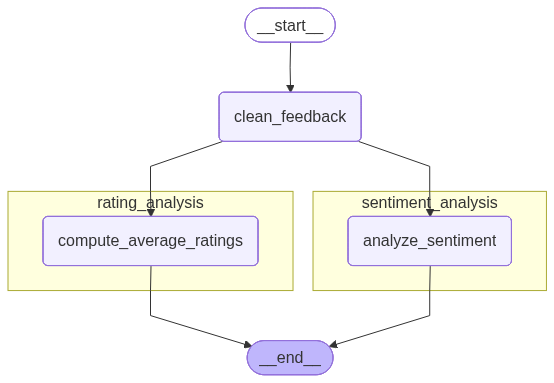

In [21]:
class MainGraphState(TypedDict):
    raw_feedback: List[FeedbackLog]
    cleaned_logs: List[FeedbackLog]
    sentiment_summary: str
    average_ratings: Dict[str, float]
    processed_logs: Annotated[List[str], add]

def clean_feedback(state):
    # Pretend to clean data
    return {"cleaned_logs": state["raw_feedback"]}

main_builder = StateGraph(MainGraphState)
main_builder.add_node("clean_feedback", clean_feedback)
main_builder.add_node("sentiment_analysis", sentiment_graph)
main_builder.add_node("rating_analysis", rating_graph)

main_builder.add_edge(START, "clean_feedback")
main_builder.add_edge("clean_feedback", "sentiment_analysis")
main_builder.add_edge("clean_feedback", "rating_analysis")
main_builder.add_edge("sentiment_analysis", END)
main_builder.add_edge("rating_analysis", END)

main_graph = main_builder.compile()
display(Image(main_graph.get_graph(xray=1).draw_mermaid_png()))

In [22]:
feedback_logs = [
    FeedbackLog(id="1", comment="Good explanation of topic", rating=5, subject="Math"),
    FeedbackLog(id="2", comment="Could be better organized", rating=3, subject="Science"),
    FeedbackLog(id="3", comment="Really good session!", rating=4, subject="Math")
]

result = main_graph.invoke({"raw_feedback": feedback_logs})
result

{'raw_feedback': [{'id': '1',
   'comment': 'Good explanation of topic',
   'rating': 5,
   'subject': 'Math'},
  {'id': '2',
   'comment': 'Could be better organized',
   'rating': 3,
   'subject': 'Science'},
  {'id': '3',
   'comment': 'Really good session!',
   'rating': 4,
   'subject': 'Math'}],
 'cleaned_logs': [{'id': '1',
   'comment': 'Good explanation of topic',
   'rating': 5,
   'subject': 'Math'},
  {'id': '2',
   'comment': 'Could be better organized',
   'rating': 3,
   'subject': 'Science'},
  {'id': '3',
   'comment': 'Really good session!',
   'rating': 4,
   'subject': 'Math'}],
 'sentiment_summary': '2 positive and 1 negative comments.',
 'average_ratings': {'Math': 4.5, 'Science': 3.0},
 'processed_logs': ['rating-log-1',
  'rating-log-2',
  'rating-log-3',
  'sentiment-log-1',
  'sentiment-log-2',
  'sentiment-log-3']}